### 1. Keep huggingface dependencies in this repo
 Requires downloading models from HuggingFace,
 Can take up to 10 minutes first run, be patient


In [ ]:
import os
os.environ['HF_HOME'] = '../models/huggingface'

# Fix for newer huggingface_hub versions
import huggingface_hub
if not hasattr(huggingface_hub, 'cached_download'):
    from huggingface_hub import hf_hub_download
    huggingface_hub.cached_download = hf_hub_download

import torch
from PIL import Image

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from diffusers import DiffusionPipeline
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-3.5-medium", dtype=torch.float32, device_map="mps")

GatedRepoError: 401 Client Error. (Request ID: Root=1-695902f2-6aeb043c29c0c85a6c7993bd;c010bbbd-0733-40b8-aca4-dc35b0c9617f)

Cannot access gated repo for url https://huggingface.co/stabilityai/stable-diffusion-3.5-medium/resolve/main/model_index.json.
Access to model stabilityai/stable-diffusion-3.5-medium is restricted. You must have access to it and be authenticated to access it. Please log in.

In [ ]:
# Download IP-Adapter model files from HuggingFace
# Run once - downloads ~2GB of models- this can take 5-15 minutes first run, be patient

from huggingface_hub import snapshot_download
from pathlib import Path
import os

model_id = "stabilityai/stable-diffusion-3.5-medium" # This is like 50 GB

# Load the pipeline for Mac (MPS) or PC (CUDA)
pipe = FluxPipeline.from_pretrained(model_id, torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload()

Models already downloaded - skipping. Delete the folder to re-download.
Models dir: ../models/ip_adapter_hf
Contents: ['image_encoder', 'ip-adapter_sd15.bin']


In [ ]:
# Model paths
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"

# IP-Adapter paths (from HuggingFace download)
image_encoder_path = "../models/ip_adapter_hf/models/image_encoder/"
ip_ckpt = "../models/ip_adapter_hf/models/ip-adapter_sd15.bin"

# Device: mps for Mac, cuda for NVIDIA GPU
device = "cpu"

In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float32)

## Image Variations

In [ ]:
from diffusers import StableDiffusionPipeline

In [9]:
# load SD pipeline- this can take 5-15 minutes first run, be patient
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float32,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


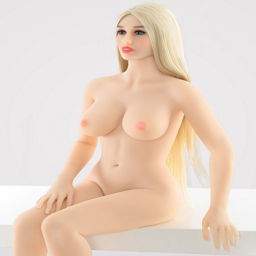

In [27]:
# read image prompt
# image = Image.open("assets/images/woman.png")
style_image = Image.open("../data/style/sex_doll2.jpg")
style_image.resize((256, 256))

In [ ]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

# Convert ALL IP-Adapter components to float32 (library defaults to float16)
ip_model.image_encoder = ip_model.image_encoder.to(dtype=torch.float32)
ip_model.image_proj_model = ip_model.image_proj_model.to(dtype=torch.float32)

# Convert the UNet attention processors that IP-Adapter adds
for name, processor in ip_model.pipe.unet.attn_processors.items():
    if hasattr(processor, 'to_k_ip'):
        processor.to_k_ip = processor.to_k_ip.to(dtype=torch.float32)
        processor.to_v_ip = processor.to_v_ip.to(dtype=torch.float32)

NameError: name 'IPAdapter' is not defined

In [ ]:
# generate image variations
# takes up to 20 minutes
images = ip_model.generate(pil_image=style_image, num_samples=4, num_inference_steps=50, seed=42)
grid = image_grid(images, 1, 4)
grid

  0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
grid.save("../outputs/ip_adapter_grid.png")

## Image-to-Image

In [ ]:
from diffusers import StableDiffusionImg2ImgPipeline

In [11]:
# load SD Img2Img pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


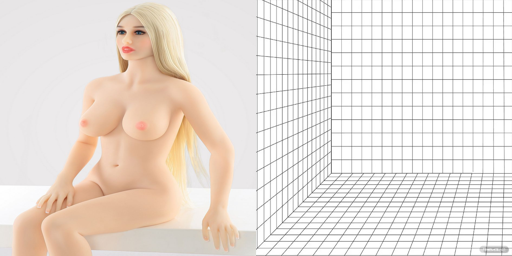

In [ ]:
# read image prompt
style_image = Image.open("../data/style/sex_doll2.jpg")
structure_image = Image.open("../data/content/grid1.jpg")

image_grid([style_image.resize((256, 256)), structure_image.resize((256, 256))], 1, 2)

In [1]:
# generate
images = ip_model.generate(pil_image=style_image, num_samples=4, num_inference_steps=50, seed=42, image=structure_image, strength=0.6)
grid = image_grid(images, 1, 4)
grid

NameError: name 'ip_model' is not defined